In [11]:
import sys, os
sys.path.append(os.path.abspath("../../build/"))

In [12]:
%matplotlib inline

import numpy as np
from tqdm import tqdm_notebook as tqdm

from wind_enrich_ia_elts_cluster_discrete import lib as winds
from core_enrich_ia_elts_cluster_discrete import lib as core

import tabulation

import betterplotlib as bpl
bpl.presentation_style()

In [13]:
winds.detailed_enrichment_init()
core.detailed_enrichment_init()

In [14]:
lt = tabulation.Lifetimes("Raiteri_96")

In [17]:
dt = 1E4

In [18]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        times[z] = np.arange(0, 50E6, dt)
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

In [19]:
generate_times([0.02, 0.01, 0.004, 0.001, 0.0005, 0.0001, 0])

<ipython-input-18-bdfe578757b4>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]


# Check the general shape of the wind ejecta

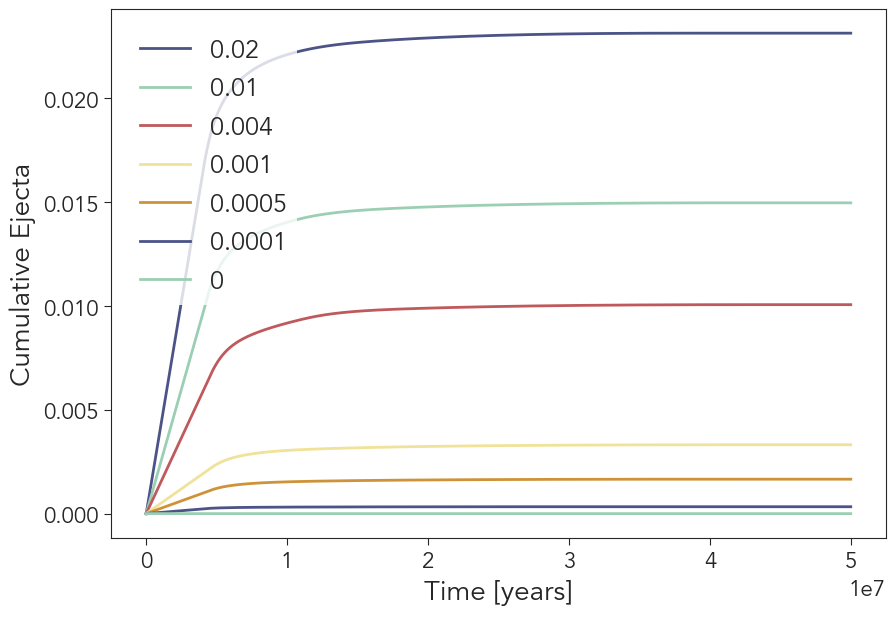

In [22]:
m_star = 1

fig, ax = bpl.subplots()

for idx_z, z in enumerate(times):
    age_50 = lt.lifetime(50.0, z)
    
    cumulative_ejecta = []
    for idx in range(len(times[z])):
        age_now = times[z][idx]
        m_now = turnoff_masses[z][idx]
        
        ejecta = core.get_cumulative_mass_winds_py(age_now, m_now, z, age_50)
        
        cumulative_ejecta.append(ejecta)
        
    ax.plot(times[z], cumulative_ejecta, lw=2, ls="-", label=z)
    

# ax.set_xscale("log")
# ax.set_yscale("log")
ax.legend()
ax.add_labels("Time [years]", "Cumulative Ejecta")
# ax.set_limits(3E7, 5E7)


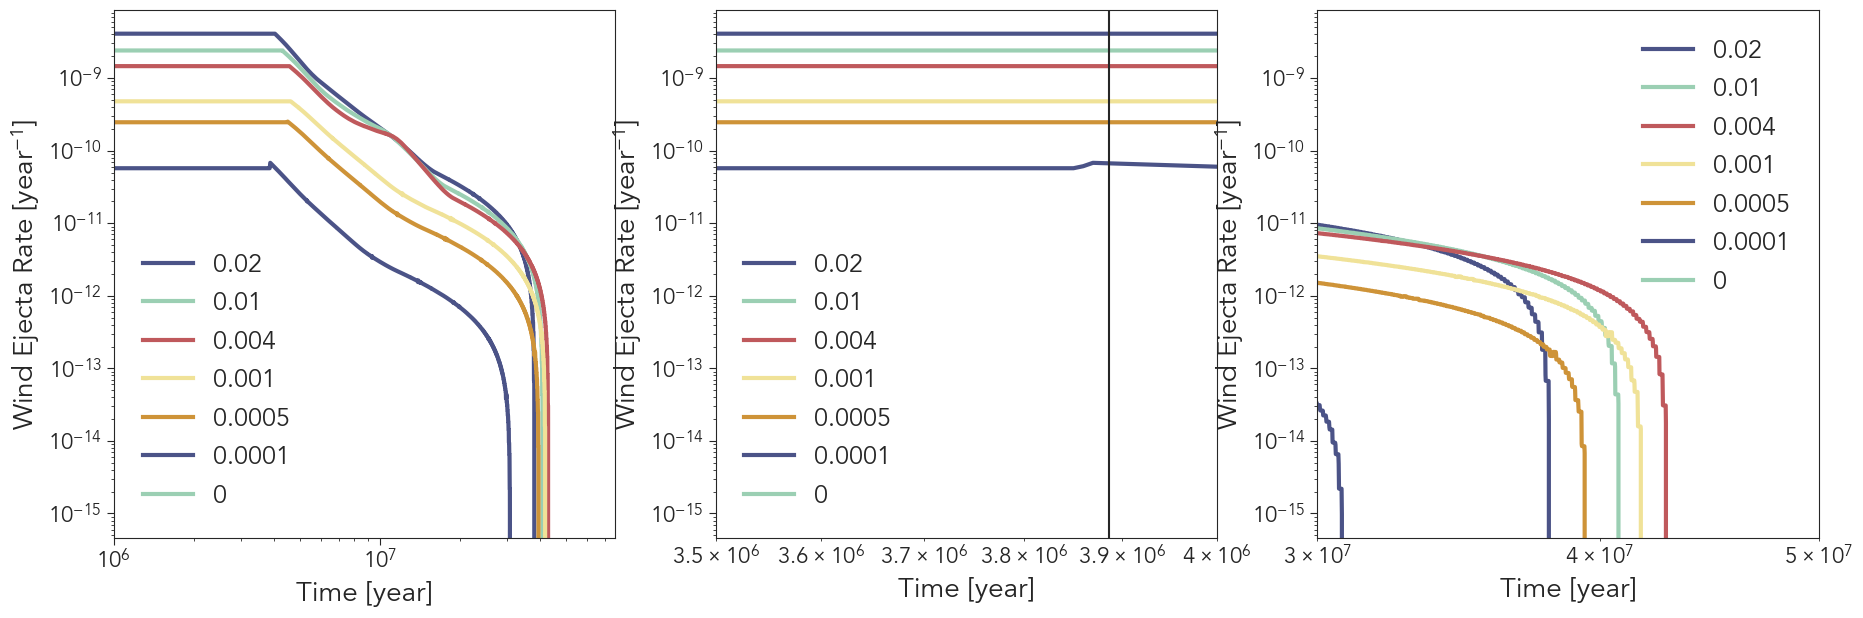

In [24]:
m_star = 1

fig, axs = bpl.subplots(ncols=3, figsize=[22, 7])

for z in times:
    
    age_50 = lt.lifetime(50.0, z)
    
    rates = []
    for idx in range(len(times[z]) - 1):
        age_now = times[z][idx]
        age_next = times[z][idx+1]
        m_now = turnoff_masses[z][idx]
        m_next = turnoff_masses[z][idx+1]
        
        ejecta = winds.get_ejecta_winds_py(age_now, age_next, 
                                           m_now, m_next, m_star, z, age_50)
        rates.append(ejecta / dt)
    
    for ax in axs:
        ax.plot(times[z][:-1], rates, label=z)
    
for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.add_labels("Time [year]", "Wind Ejecta Rate [year$^{-1}$]")
    
axs[0].set_limits(x_min=1E6)
axs[1].set_limits(3.5E6, 4E6)
axs[2].set_limits(3E7, 5E7)
axs[1].axvline(lt.lifetime(49.5, 0.0001))

This discreteness isn't a problem. The individual chunks are the segments between two mass points. We linearly interpolate in mass, so the rate with respect to mass should be a constant between the two points. Since the age to mass relation isn't linear, there will be some slight variation in each segment. But this discreteness is an indication that things are working as expected.

In [11]:
rates[-11000:-10000]

[5.635648957051653e-14,
 5.635394603221988e-14,
 5.635139316978455e-14,
 5.634882968216792e-14,
 5.63462661945513e-14,
 5.6343707260583796e-14,
 5.634070250268297e-14,
 5.6340758664355505e-14,
 5.633431373296138e-14,
 5.633346740474554e-14,
 5.633265642152052e-14,
 5.632663584685671e-14,
 5.6325767184076114e-14,
 5.6323175507203006e-14,
 5.632111704095832e-14,
 5.6317525296001315e-14,
 5.6317612682696416e-14,
 4.9119083366661044e-14,
 3.730995352078936e-14,
 3.730774153151706e-14,
 3.730699473306065e-14,
 3.730386052142043e-14,
 3.7302754635204495e-14,
 3.730123328271606e-14,
 3.730073953704671e-14,
 3.729663886758994e-14,
 3.729619239313531e-14,
 3.729407256104767e-14,
 3.729299768301386e-14,
 3.729087481516014e-14,
 3.728899632647609e-14,
 3.7288525132211925e-14,
 3.7285877076825847e-14,
 3.7285040506429555e-14,
 3.728208822391388e-14,
 3.728047232899601e-14,
 3.7279465322018204e-14,
 3.7278085566333497e-14,
 3.727450162763213e-14,
 3.727443765970395e-14,
 3.7272512333486054e-14,
 3.

Examining this carefully shows how the rate has nearly constant values when its between two mass points of the table (with the only variation happening when a new mass point is reached

# Test very small fragment of mass range for cumulative winds to check smoothness

In [12]:
z = 0.02
ms = np.linspace(8, 8.05, 1000)
ages = np.array([lt.lifetime(m, z) for m in ms])
age_50 = lt.lifetime(50, z)

In [13]:
ejected_masses = [winds_elements.get_cumulative_mass_winds_py(age, m, z, age_50) 
                  for m, age in zip(ms, ages)]

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


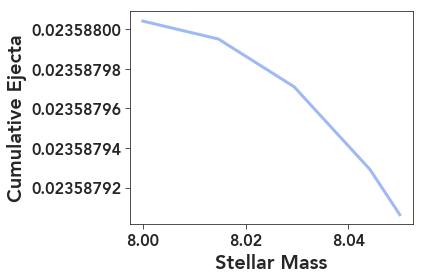

In [14]:
fig, ax = bpl.subplots()
ax.plot(ms, ejected_masses)
ax.add_labels("Stellar Mass", "Cumulative Ejecta")
# ax.set_limits(35, 34)

This shows how there will be segments where the slope is constant (with respect to mass). This is what leads to the segments in the rates above.

# Check what's going on with the bump at early times

First I'll check that the interpolation is working as expected. The metallicities with grid points in the table are $Z=0, 0.001$

In [15]:
from scipy import interpolate

In [16]:
ejecta_z0_m50 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(50, 0), 
                                                            50, 0, lt.lifetime(50, 0))
ejecta_z0_001_m50 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(50, 0.001), 
                                                                50, 0.001, lt.lifetime(50, 0.001))
ejecta_z0_0001_m50 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(50, 0.0001), 
                                                                50, 0.0001, lt.lifetime(50, 0.0001))

interp_50 = interpolate.interp1d(x=[0, 0.001], y=[ejecta_z0_m50, ejecta_z0_001_m50],
                              kind="linear")
print(interp_50(0.0001))
print(ejecta_z0_0001_m50)

0.000225708032
0.000225708032


Now do the same for the 49 solar mass. But pick a mass in the table.

In [17]:
m_table = 49.5434927907

ejecta_z0_m49 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(m_table, 0), 
                                                            m_table, 0, lt.lifetime(50, 0))
ejecta_z0_001_m49 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(m_table, 0.001), 
                                                                m_table, 0.001, lt.lifetime(50, 0.001))
ejecta_z0_0001_m49 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(m_table, 0.0001), 
                                                                m_table, 0.0001, lt.lifetime(50, 0.0001))

interp_49 = interpolate.interp1d(x=[0, 0.001], y=[ejecta_z0_m49, ejecta_z0_001_m49],
                              kind="linear")
print(interp_49(0.0001))
print(ejecta_z0_0001_m49)

0.0002269834572
0.0002269834572


And try 51, just to check that part too.

In [18]:
m_earyl = 51

ejecta_z0_m51 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(m_earyl, 0), 
                                                            m_earyl, 0, lt.lifetime(50, 0))
ejecta_z0_001_m51 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(m_earyl, 0.001), 
                                                                m_earyl, 0.001, lt.lifetime(50, 0.001))
ejecta_z0_0001_m51 = winds_elements.get_cumulative_mass_winds_py(lt.lifetime(m_earyl, 0.0001), 
                                                                m_earyl, 0.0001, lt.lifetime(50, 0.0001))

interp_51 = interpolate.interp1d(x=[0, 0.001], y=[ejecta_z0_m51, ejecta_z0_001_m51],
                              kind="linear")
print(interp_51(0.0001))
print(interp_50(0.0001) * lt.lifetime(m_earyl, 0.0001) / lt.lifetime(50, 0.0001))
print(ejecta_z0_0001_m51)

0.00022299754012765162
0.00022344670461545127
0.00022344670461545127


This is all working as I'd planned it, but apparently that's leading to the issue.

Check that the rates give what I expect at the grid points.

Check that the total ejecta at 50 solar masses matches correctly. We'll check every possible way of calculating the cumulative ejecta, then compare them.

In [19]:
from scipy import integrate

In [20]:
z = 0.001
age_50 = lt.lifetime(50, z)

cumulative_c_direct = winds_elements.get_cumulative_mass_winds_py(age_50, 50, z, age_50)
cumulative_py_direct = tab.cumulative_mass_loss_winds(50, z)

def integrand_py(age):
    return tab.mass_loss_rate_winds(age, z)
cumulative_py_integrate = integrate.quad(integrand_py, 0, age_50)[0]

def integrand_c(age):
    return winds_elements.get_ejecta_winds_py(1E6, 2E6, 
                                              lt.turnoff_mass(1E6, z), 
                                              lt.turnoff_mass(2E6, z), 
                                              1, z, age_50) / 1E6
cumulative_c_integrate = integrate.quad(integrand_c, 0, age_50)[0]


rate_py_direct = tab.mass_loss_rate_winds(1E6, z)
cumulative_py_integrate_simple = rate_py_direct * age_50

rate_c_direct = winds_elements.get_ejecta_winds_py(1E6, 2E6, 
                                              lt.turnoff_mass(1E6, z), 
                                              lt.turnoff_mass(2E6, z), 
                                              1, z, age_50) / 1E6
cumulative_c_integrate_simple = rate_c_direct * age_50


print(cumulative_py_direct)
print(cumulative_py_integrate_simple)
print(cumulative_py_integrate)
print(cumulative_c_direct)
print(cumulative_c_integrate_simple)
print(cumulative_c_integrate)

0.0022570803203938016
0.0022570121402000058
0.0022570121402000058
0.00225708032
0.00225708032
0.00225708032


Here all the C methods agree, which is as expected. The direct method of getting the ejecta agrees with the C code, as expected. But the methods using the rates do not agree with this! So I should check every method possible of getting the rates.

In [21]:
z = 0.001
age_50 = lt.lifetime(50, z)

rate_py_differentiate_simple = cumulative_py_direct / age_50
rate_c_differentiate_simple = cumulative_c_direct / age_50


print(rate_py_direct)
print(rate_py_differentiate_simple)
print(rate_c_direct)
print(rate_c_differentiate_simple)

4.883588631866639e-10
4.883736156114918e-10
4.883736155262833e-10
4.883736155262833e-10


So here the only outlier is the Python rate calculation, which is slightly off from the other two. 

Check that the ejecta my C code gives matches the total.

In [22]:
print(winds_elements.get_cumulative_mass_winds_py(lt.lifetime(7, z), 7, z, age_50))
print(tab.cumulative_mass_loss_winds(7, z))

0.003380253983
0.003380253983319719


And that it does so for any timestep scheme.

In [23]:
for z in tab.sn_ii_model.sn.metallicities:
    age_50 = lt.lifetime(50.0, z)
    
    cumulative_ejecta_elements = []
    cumulative_ejecta_no_elements = []
    for idx in range(len(times[z])):
        age_now = times[z][idx]
        m_now = turnoff_masses[z][idx]
        
        ejecta_elts = winds_elements.get_cumulative_mass_winds_py(age_now, m_now, z, age_50)
        
        cumulative_ejecta_elements.append(ejecta_elts)
        
    print(cumulative_ejecta_elements[-1])
    print(tab.cumulative_mass_loss_winds(7, z))

0.0
0.0
0.003380253983
0.003380253983319719
0.01025927211
0.01025927210817167
0.02358800408
0.023588004079895194


And does so even when we interpolate in metallicity.

In [25]:
z = 0.0001
age_50 = lt.lifetime(50.0, z)

cumulative_ejecta_elements = []
cumulative_ejecta_no_elements = []
for idx in range(len(times[z])):
    age_now = times[z][idx]
    m_now = turnoff_masses[z][idx]

    ejecta_elts = winds_elements.get_cumulative_mass_winds_py(age_now, m_now, z, age_50)

    cumulative_ejecta_elements.append(ejecta_elts)
        
print(cumulative_ejecta_elements[-1])

true_0 = tab.cumulative_mass_loss_winds(7, 0)
true_1 = tab.cumulative_mass_loss_winds(7, 0.001)
interp = interpolate.interp1d(x=[0, 0.001], y=[true_0, true_1], kind="linear")
print(interp(z))

0.0003380253983
0.00033802539833197194


In conclusion I don't know what to make of this. I don't think the issues in comparing the python rate to C rates are meaningful. I think they are probably due to numerical noise, since there's a lot of integration happening there. But the spike at early times is real, and I actually think it's unavoidable. It has to be because the wind calculations, even if they are tabulated in terms of stellar mass, rely on lifetimes. We have to know what fraction of a star's mass is ejected when the X solar mass model is dying, and to do this we have to know the lifetime. When we interpolate in metallicity at a given mass, we correct for the lifetime of the stars, but this secondary dependence on age is unavoidable (unless we did the integration in runtime). Variations in lifetimes can cause the rates to look slightly wonky. but it's worth noting that the cumulative ejecta is still correct!

In [24]:
# m_star = 1

# fig, axs = bpl.subplots(ncols=3, figsize=[22, 7])

# for idx_z, z in enumerate(tab.sn_ii_model.sn.metallicities):
    
#     age_50 = lt.lifetime(50.0, z)
    
#     rates_c = []
#     rates_tab = []
#     for idx in tqdm(range(len(times[z]) - 1)):
#         age_now = times[z][idx]
#         age_next = times[z][idx+1]
#         m_now = turnoff_masses[z][idx]
#         m_next = turnoff_masses[z][idx+1]
        
#         ejecta = winds_elements.get_ejecta_winds_py(age_now, age_next, 
#                                                     m_now, m_next, m_star, z, age_50)
#         rates_c.append(ejecta / dt)
        
#         rates_tab.append(tab.mass_loss_rate_winds(age_now, z))
    
    
    
#     for ax in axs:
#         ax.plot(times[z][:-1], rates_c, c=bpl.color_cycle[idx_z], label="{} - C".format(z))
#         ax.plot(times[z][:-1], rates_tab, c=bpl.color_cycle[idx_z], label="{} - Py".format(z), ls=":", lw=5)
    
    
    
# for ax in axs:
#     ax.set_xscale("log")
#     ax.set_yscale("log")
#     ax.legend()
#     ax.add_labels("Time [year]", "Wind Ejecta Rate [year$^{-1}$]")
    
# axs[0].set_limits(x_min=3E6)
# axs[1].set_limits(3.5E6, 4E6)
# axs[2].set_limits(3E7, 5E7)
# axs[1].axvline(lt.lifetime(49.5, 0.0001))

This plot, when run, shows that the rates do match reasonably well.